In [15]:
# from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import imgaug.augmenters as iaa
import random
import cv2
from sklearn.model_selection import StratifiedKFold
from self_htr import Self_HTR


In [16]:
aug = False
plot = True if not aug else False

In [17]:
random_state = 42
random.seed(random_state)

aug_seq = iaa.Sequential([
            iaa.Rotate((-10, 10), random_state=random_state),                 
            iaa.ShearX((-10, 10), random_state=random_state),                  
            iaa.ShearY((-10, 10), random_state=random_state),
        ])

def augment(image):
    kernel = np.ones((2, 2), np.uint8) 
    if random.random() < 0.5:
        image = cv2.erode(image, kernel, iterations=1) 
    else:
        image = cv2.dilate(image, kernel, iterations=1) 
    image = aug_seq.augment_image(image)
    return image

In [18]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_total_data = np.concatenate([x_train, np.array(x_test)])
y_total_data = np.concatenate([y_train, y_test])


x_train, gan_train, y_train, gan_y_train = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

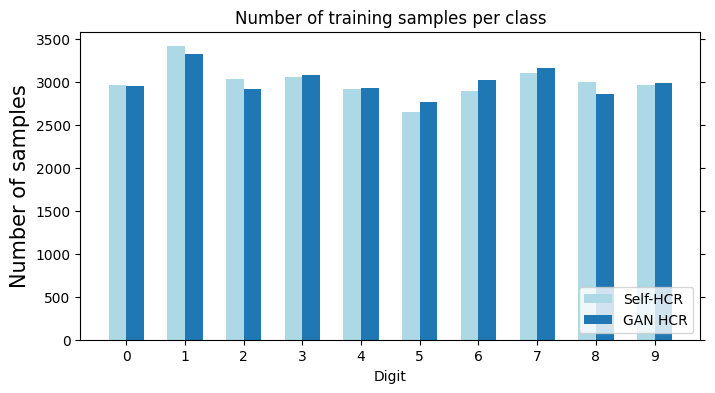

[6903 7877 6990 7141 6824 6313 6876 7293 6825 6958]


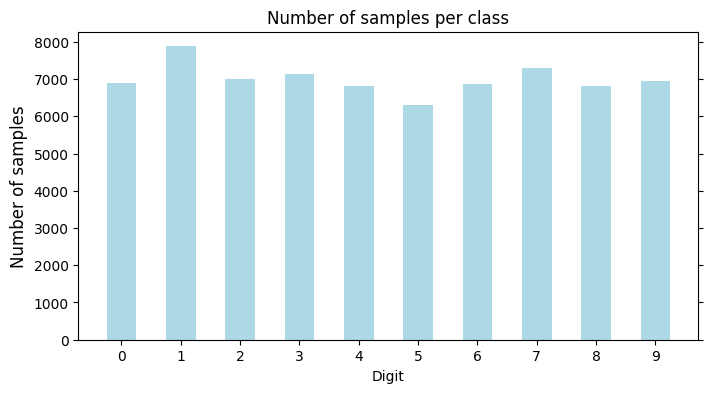

In [6]:
if plot:
	plt.rcParams['figure.figsize'] = [8, 4]
	fig, ax = plt.subplots(nrows=1, ncols=1)

	_, train_counts = np.unique(y_train, return_counts=True)
	_, gan_train_counts = np.unique(gan_y_train, return_counts=True)

	barWidth = 0.3
	br1 = np.arange(len(train_counts)) 
	br2 = [x + barWidth for x in br1] 

	ax.bar(br1, train_counts, width=barWidth, color='lightblue', label="Self-HCR")
	ax.bar(br2, gan_train_counts, width=barWidth, label="GAN HCR")
	# ax.set_xticklabels(labels=[i for i in range(10)])
	ax.tick_params(left = True, right = True , labelleft = True , 
					labelbottom = True, bottom = True) 
	plt.xticks([r + (barWidth/2) for r in range(len(train_counts))], 
			['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
	plt.ylabel('Number of samples', fontsize = 15) 
	plt.xlabel('Digit')
	plt.title('Number of training samples per class')
	plt.legend(loc="lower right")
	plt.savefig('./datavis/classbal_mnist_training.png', dpi=300)
	plt.show()

	plt.rcParams['figure.figsize'] = [8, 4]
	fig, ax = plt.subplots(nrows=1, ncols=1)

	_, total_counts = np.unique(y_total_data, return_counts=True)
	print(total_counts)

	barWidth = 0.5
	br1 = np.arange(len(train_counts)) 

	ax.bar(br1, total_counts, width=barWidth, color='lightblue')
	# ax.set_xticklabels(labels=[i for i in range(10)])
	ax.tick_params(left = True, right = True , labelleft = True , 
					labelbottom = True, bottom = True) 
	plt.xticks([r for r in range(len(train_counts))], 
			['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
	plt.ylabel('Number of samples', fontsize = 12) 
	plt.xlabel('Digit')
	plt.title('Number of samples per class')
	plt.savefig('./datavis/classbal_mnist.png', dpi=300)
	plt.show()


### Checking the data

In [6]:
if plot:
	tsne = TSNE(n_components=2)
	tsne_results = tsne.fit_transform(x_total_data.reshape(x_total_data.shape[0], 28*28))

	# x_train_tsne_results = tsne.fit_transform(x_train.reshape(x_train.shape[0], 28*28))
	# gan_train_tsne_results = tsne.fit_transform(gan_train.reshape(gan_train.shape[0], 28*28))



In [7]:
def plot_tsne(results, y_data, file_name):
	plt.rcParams['figure.figsize'] = [20, 15]
	fig = plt.figure()
	scatter = plt.scatter(results[:,0], results[:,1], c=y_data)
	handles, _ = scatter.legend_elements(prop='colors')
	plt.legend(handles, np.unique(y_total_data), prop = { "size": 20 }, loc="upper right")
	plt.title("t-SNE MNIST", fontsize=30)
	plt.xlabel("First t-SNE", fontsize=20)
	plt.ylabel("Second t-SNE", fontsize=20)
	plt.yticks(fontsize=20)
	plt.xticks(fontsize=20)
	plt.savefig(file_name, dpi=300)
	plt.show()


In [ ]:
if plot:
	plot_tsne(tsne_results, y_total_data, "./datavis/mnist_tsne.png")
	


In [19]:
if aug:
    x_train_aug = np.array([augment(x) for x in x_train.astype("float32")])
    x_train = np.concatenate([x_train, np.array(x_train_aug)])
    y_train = np.concatenate([y_train, y_train])

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))


x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [20]:
def make_htr_model():
    initializer = tf.keras.initializers.HeUniform(seed=42)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1],  kernel_initializer=initializer))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3, seed=42))
    
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1],  kernel_initializer=initializer))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3, seed=42))

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same',  kernel_initializer=initializer))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10,  kernel_initializer=initializer))
    model.add(tf.keras.layers.Softmax())
    return model

# Supervised Handwritten character Recognition

In [21]:
super_htr_model = make_htr_model()    
super_htr_model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_120 (LeakyReLU)  (None, 14, 14, 64)       0         
                                                                 
 dropout_80 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_121 (Conv2D)         (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_121 (LeakyReLU)  (None, 7, 7, 64)         0         
                                                                 
 dropout_81 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 conv2d_122 (Conv2D)         (None, 7, 7, 128)       

In [29]:
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

super_htr_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['acc'],
)

res = {}
preds = {}

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
    print("Starting fold ", i)
    x_train_fold = [x_train[i] for i in train_index]
    x_valid_fold = [x_train[i] for i in valid_index]

    y_train_fold = [y_train[i] for i in train_index]
    y_valid_fold = [y_train[i] for i in valid_index]

    y_train_fold = tf.keras.utils.to_categorical(y_train_fold, 10)
    y_valid_fold = tf.keras.utils.to_categorical(y_valid_fold, 10)

    dataset = tf.data.Dataset.from_tensor_slices((x_train_fold, y_train_fold))
    dataset = dataset.shuffle(buffer_size=1024).batch(256)

    val_dataset = tf.data.Dataset.from_tensor_slices((x_valid_fold, y_valid_fold))
    val_dataset = val_dataset.batch(256)

    super_htr_model = make_htr_model()    
    super_htr_model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['acc'],
    )
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    res[i] = super_htr_model.fit(dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback])
    preds[i] = super_htr_model.predict(x_test)

    super_htr_model.save(f'./mnist_super_hcr_f{i}.keras')

Starting fold  0
Epoch 1/100
94/94 [==============================] - 2s 16ms/step - loss: 0.4727 - acc: 0.8552 - val_loss: 0.2119 - val_acc: 0.9402
Epoch 2/100
94/94 [==============================] - 1s 15ms/step - loss: 0.1913 - acc: 0.9423 - val_loss: 0.1638 - val_acc: 0.9517
Epoch 3/100
94/94 [==============================] - 1s 15ms/step - loss: 0.1446 - acc: 0.9564 - val_loss: 0.1209 - val_acc: 0.9637
Epoch 4/100
94/94 [==============================] - 1s 15ms/step - loss: 0.1145 - acc: 0.9640 - val_loss: 0.1020 - val_acc: 0.9685
Epoch 5/100
94/94 [==============================] - 1s 15ms/step - loss: 0.1032 - acc: 0.9678 - val_loss: 0.0963 - val_acc: 0.9717
Epoch 6/100
94/94 [==============================] - 1s 15ms/step - loss: 0.0910 - acc: 0.9707 - val_loss: 0.0861 - val_acc: 0.9750
Epoch 7/100
94/94 [==============================] - 1s 14ms/step - loss: 0.0802 - acc: 0.9742 - val_loss: 0.0899 - val_acc: 0.9732
Epoch 8/100
94/94 [==============================] - 1s 14m

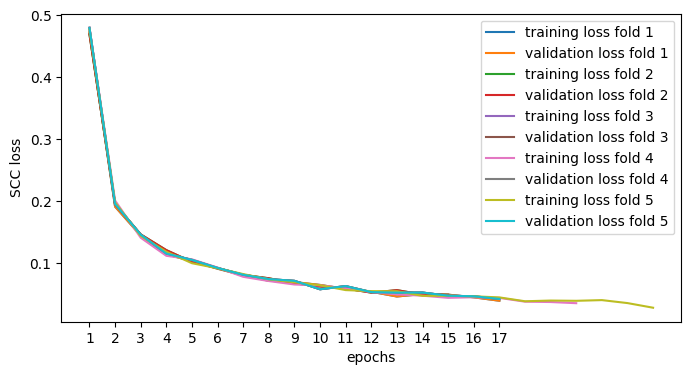

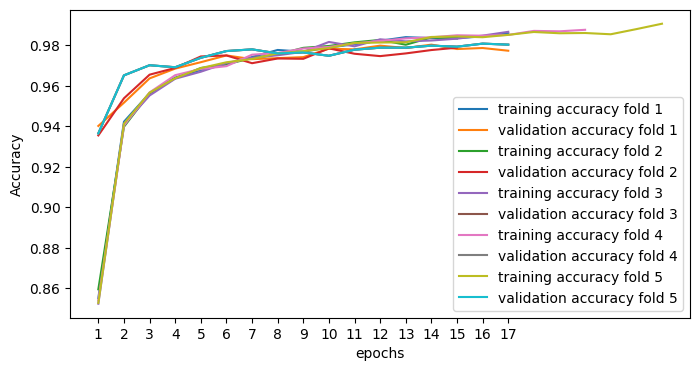

In [31]:
tr_loss = []
val_loss = []

tr_acc = []
val_acc = []

for i in range(len(res.keys())):
	tr_loss.append(list(res[i].history['loss']))
	val_loss.append(list(res[i].history['loss']))

	tr_acc.append(list(res[i].history['acc']))
	val_acc.append(list(res[i].history['val_acc']))


fig = plt.figure(figsize=(8, 4))

max_epochs = max(len(tr_loss[0]), len(tr_loss[1]), len(tr_loss[2]))
plt.plot(np.arange(len(tr_loss[0])), tr_loss[0], label="training loss fold 1")
plt.plot(val_loss[0], label="validation loss fold 1")
plt.plot(np.arange(len(tr_loss[1])),tr_loss[1],  label="training loss fold 2")
plt.plot(val_loss[1], label="validation loss fold 2")
plt.plot(np.arange(len(tr_loss[2])), tr_loss[2],  label="training loss fold 3")
plt.plot(val_loss[2], label="validation loss fold 3")
plt.plot(np.arange(len(tr_loss[3])), tr_loss[3],  label="training loss fold 4")
plt.plot(val_loss[2], label="validation loss fold 4")
plt.plot(np.arange(len(tr_loss[4])), tr_loss[4],  label="training loss fold 5")
plt.plot(val_loss[2], label="validation loss fold 5")
plt.legend()
plt.xticks(np.arange(0, max_epochs), labels = np.arange(1, max_epochs + 1))
plt.xlabel("epochs")
plt.ylabel("SCC loss")
if aug:
	plt.savefig("./results/super_hcr_loss_aug.png", dpi=300)
else:
	plt.savefig("./results/super_hcr_loss.png", dpi=300)
plt.show()


fig = plt.figure(figsize=(8, 4))

max_epochs = max(len(tr_acc[0]), len(tr_acc[1]), len(tr_acc[2]))
plt.plot(np.arange(len(tr_acc[0])), tr_acc[0], label="training accuracy fold 1")
plt.plot(val_acc[0], label="validation accuracy fold 1")
plt.plot(np.arange(len(tr_acc[1])),tr_acc[1],  label="training accuracy fold 2")
plt.plot(val_acc[1], label="validation accuracy fold 2")
plt.plot(np.arange(len(tr_acc[2])), tr_acc[2],  label="training accuracy fold 3")
plt.plot(val_acc[2], label="validation accuracy fold 3")
plt.plot(np.arange(len(tr_acc[3])), tr_acc[3],  label="training accuracy fold 4")
plt.plot(val_acc[2], label="validation accuracy fold 4")
plt.plot(np.arange(len(tr_acc[4])), tr_acc[4],  label="training accuracy fold 5")
plt.plot(val_acc[2], label="validation accuracy fold 5")
plt.legend()
plt.xticks(np.arange(0, max_epochs), labels = np.arange(1, max_epochs + 1))
plt.xlabel("epochs")
plt.ylabel("Accuracy")
if aug:
	plt.savefig("./results/super_hcr_acc_aug.png", dpi=300)
else:
	plt.savefig("./results/super_hcr_acc.png", dpi=300)
plt.show()

Mean val acc: 0.07950844019651412 std val acc: 0.0016937012220372783
(10000, 10)
Test accuracy: 0.9876


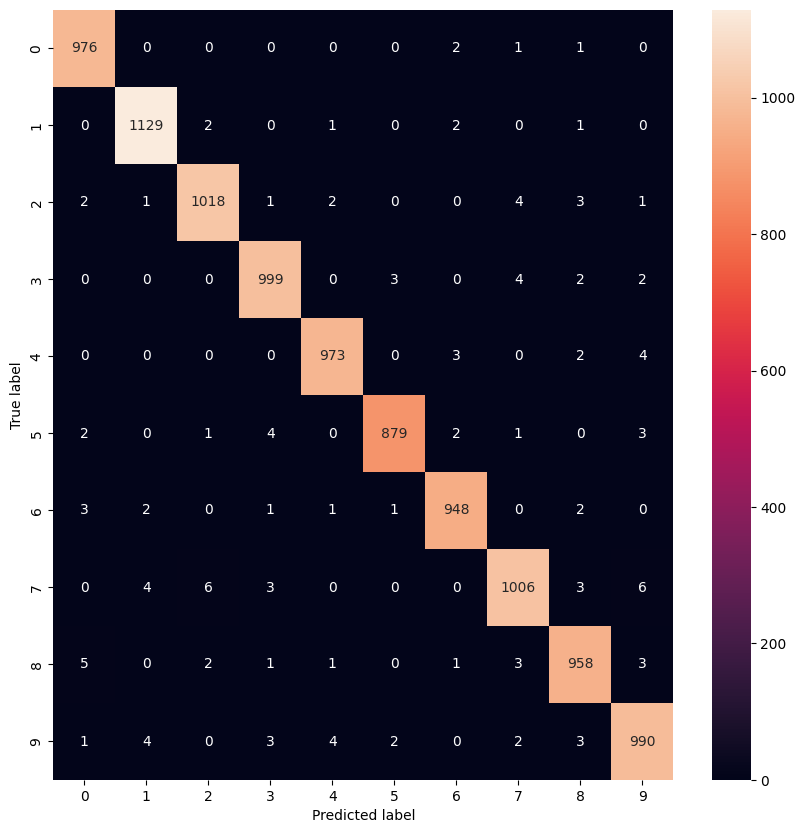

In [32]:
mean_val_acc = np.mean([res[i].history['val_loss'][-1] for i in range(len(res.keys()))])
stdval_acc = np.std([res[i].history['val_loss'][-1] for i in range(len(res.keys()))])

print("Mean val acc:", mean_val_acc, "std val acc:", stdval_acc)

y_pred = np.mean([preds[i] for i in range(len(preds.keys()))], axis=0)
print(y_pred.shape)

y_pred = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1)

accuracy = accuracy_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)

print("Test accuracy:", accuracy)

fig = plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='g')
plt.ylabel("True label")
plt.xlabel("Predicted label")
if aug:
	plt.savefig('super_hcr_confmat_aug.png')
plt.show()

# Self-supervised handwritten character recognition

### Plotting vgg features

In [7]:
def get_vgg_model(n_layer, summary=False):
	model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3), pooling=None)
	if summary:
		for num, layer in enumerate(model.layers):
			print(num, layer)
	input_data = tf.keras.Input(shape=(28, 28, 3))
	resized_input = tf.keras.layers.Resizing(32, 32)(input_data)
	desired_layer_output = tf.keras.models.Sequential(model.layers[:n_layer])(resized_input)
	vgg_model = tf.keras.Model(inputs=input_data, outputs=desired_layer_output)
	if summary:
		vgg_model.summary()
	return vgg_model


In [19]:
vgg_model = get_vgg_model(3, summary=True)

0 <keras.engine.input_layer.InputLayer object at 0x000001B1AC430F70>
1 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1E78997E0>
2 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1E7DDBB50>
3 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001B1AC39BC70>
4 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1AC430B80>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B198D045B0>
6 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001B1E7D968F0>
7 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1DDFF98D0>
8 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1DDFF9000>
9 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1E7D97040>
10 <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001B1DE0C0880>
11 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B1DE0C3A00>
12 <keras.layers.convolutional.conv2d.Conv2D object at 0x000001B0014CD210>
13 <keras.layers.co

In [9]:
# x_total_data = np.concatenate([x_train, x_val])
# y_total_data = np.concatenate([np.argmax(y_train, axis=1), np.argmax(y_val, axis=1)])

# print(len(x_total_data))

total_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
total_dataset = total_dataset.shuffle(buffer_size=1024).batch(1024)

# layers = [5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18]
# layers = [12, 13, 14, 16, 17, 18]

# for layer in layers:
layer = 18
print("convolution:", layer)
vgg_features = []
label_batches = []

vgg_model = get_vgg_model(layer)

for batch in total_dataset:
	images, labels = batch
	images_in = tf.concat([images] * 3, axis=-1)
	feats = vgg_model(images_in)
	feats = tf.reshape(feats, [tf.shape(feats)[0], -1]).numpy()
	vgg_features += feats.tolist()
	label_batches += labels.numpy().tolist()

print("computed features, starting tsne...")

if plot:
	tsne = TSNE(n_components=2)
	vgg_tsne_results = tsne.fit_transform(np.array(vgg_features))

	print("Finished tsne dimensionality reduction")

	plt.rcParams['figure.figsize'] = [20, 15]
	fig = plt.figure()
	scatter = plt.scatter(vgg_tsne_results[:,0], vgg_tsne_results[:,1], c=label_batches)
	handles, _ = scatter.legend_elements(prop='colors')
	plt.legend(handles, np.unique(label_batches), prop = { "size": 15 }, loc="upper right")
	plt.title(f"Self-HCR dataset vgg features {layer}th convolution", fontsize=20)
	plt.xlabel("First t-SNE", fontsize=20)
	plt.ylabel("Second t-SNE", fontsize=20)
	plt.yticks(fontsize=20)
	plt.xticks(fontsize=20)
	plt.savefig(f"./datavis/selfhcr_vgg_tsne_conv{layer}.png", dpi=300)
	plt.show()


convolution: 18


KeyboardInterrupt: 

In [ ]:
if plot:
	plt.rcParams['figure.figsize'] = [20, 15]
	fig = plt.figure()
	scatter = plt.scatter(vgg_tsne_results[:,0], vgg_tsne_results[:,1], c=label_batches)
	handles, _ = scatter.legend_elements(prop='colors')
	plt.legend(handles, np.unique(label_batches), prop = { "size": 20 }, loc="upper right")
	plt.title("Self-HCR dataset vgg features 8th convolution", fontsize=30)
	plt.xlabel("First t-SNE", fontsize=20)
	plt.ylabel("Second t-SNE", fontsize=20)
	plt.yticks(fontsize=20)
	plt.xticks(fontsize=20)
	# plt.savefig("./datavis/selfhcr_vgg_tsne_conv8.png", dpi=300)
	plt.show()

### Generator model

In [8]:
mnist_gen = tf.keras.models.load_model("./gan_model/mnist_gan_199.keras")
mnist_gen.summary()

# vgg_model = get_vgg_model(layer)


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6762)              939918    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6762)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 138)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      282752    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                               

In [9]:
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [10]:
def save_images(epoch, imgs, labels, pred_labels, true_imgs, loss_dir, layer, plot=False):
    labels_numbers = np.argmax(labels, axis=1)
    pred_labels_numbers = np.argmax(pred_labels, axis=1)

    fig = plt.figure(figsize=(16, 8))
    plot_idx = 1
    print(imgs.shape, true_imgs.shape)
    for i in range(imgs.shape[0]):
        # print(losses[i])
        fig.add_subplot(4, 8, plot_idx )
        pred_str = ""
        # print(pred_labels[i])
        for j in pred_labels[i]:
            pred_str += "," + str(j)[:4]
        if loss_dir != 'vgg':
            plt.imshow(true_imgs[i, :, :] * 255, cmap='gray')
        else:
            plt.imshow(true_imgs[i, :, :, 0] * 255, cmap='gray')
        plt.title(f"gt: {labels_numbers[i]}, \npred: {pred_labels_numbers[i]}\n" + pred_str, fontsize=6.5)
        plt.axis('off')
        fig.add_subplot(4, 8, plot_idx + 1)
        plt.imshow(imgs[i, :, :, 0] * 255, cmap='gray')
        plt.axis('off')
 
        plot_idx += 2
    dir_path = './synth_imgs/' + loss_dir +'/'
    if loss_dir == 'vgg':
        dir_path = './synth_imgs/' + loss_dir + '_'+ str(layer) + '/'
    os.makedirs(dir_path, exist_ok=True)
    plt.savefig(dir_path + 'images_at_epoch_{:04d}.png'.format(epoch))
    if plot:
        plt.show()
    plt.close()


### Traning Self-HTR

Cross-validation

In [11]:
folds = []
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
    print("Starting fold ", i)
    x_train_fold = [x_train[i] for i in train_index]
    x_valid_fold = [x_train[i] for i in valid_index]

    y_train_fold = [y_train[i] for i in train_index]
    y_valid_fold = [y_train[i] for i in valid_index]

    y_train_fold = tf.keras.utils.to_categorical(y_train_fold, 10)
    y_valid_fold = tf.keras.utils.to_categorical(y_valid_fold, 10)

    folds.append((x_train_fold, y_train_fold, x_valid_fold, y_valid_fold))

Starting fold  0
Starting fold  1
Starting fold  2
Starting fold  3
Starting fold  4


training across different vgg layers

In [14]:
from tqdm import tqdm
from self_htr import Self_HTR



boundaries = [1000, 3000, 5000]
values = [1e-3, 3e-4, 1e-4, 1e-5]

loss_name = 'vgg'
if loss_name == 'vgg':
    layers = [10, 14]
else:
    layers = [0]
    
res_csv = f"./results/self_hcr/{loss_name}.csv"
res_dir = f'./results/self_hcr/'
os.makedirs(res_dir, exist_ok=True)

with open(res_csv, 'w') as res_f:
    for layer in layers:
        vgg_model = get_vgg_model(layer)

        res_dir = f'./results/self_hcr/{loss_name}_{layer}'
        os.makedirs(res_dir, exist_ok=True)
        res = {}

        for fold in range(len(folds)):

            dataset = tf.data.Dataset.from_tensor_slices((folds[fold][0], folds[fold][1]))
            dataset = dataset.shuffle(buffer_size=1024).batch(256)

            val_dataset = tf.data.Dataset.from_tensor_slices((folds[fold][2], folds[fold][3]))
            val_dataset = val_dataset.batch(256)

            htr_model = make_htr_model() 

            # layers = [5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18]

            learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
                boundaries, values)

            optimizer = tf.keras.optimizers.Adam(learning_rate_fn, beta_1=0.9)

            m = tf.keras.metrics.Accuracy(
                name="accu",
                dtype=None)

            self_htr = Self_HTR(make_htr_model(), mnist_gen, optimizer, loss_name, layer, latent_dim, m )

            res[fold] = {'epoch_loss':[], 'val_loss': [], 'acc':[], 'val_acc':[]}

            min_val_loss = 1000000
            patience = 5
            pat_count = 1

            for epoch in tqdm(range(100)):
                batch_losses = []
                batch_acc = []
                for batch in dataset:
                    loss, acc = self_htr.train_step(batch)
                    
                    batch_losses.append(loss)
                    batch_acc.append(acc)

                res[fold]['epoch_loss'].append(np.mean(batch_losses))
                res[fold]['acc'].append(np.mean(batch_acc))
                
                val_loss, val_acc, synth_imgs, x_val, y_val, y_preds = self_htr.validate(val_dataset)

                # count patience for early stopping
                if val_loss < min_val_loss: 
                    min_val_loss = val_loss
                    pat_count = 1
                else:
                    pat_count += 1

                save_images(epoch, synth_imgs, y_val, y_preds, x_val, loss_name, layer)
                res[fold]['val_loss'].append(val_loss)
                res[fold]['val_acc'].append(val_acc)
                print(f"epoch: {epoch} loss: {res[fold]['epoch_loss'][epoch]} val_loss: {val_loss} acc: {res[fold]['acc'][epoch]} val_acc: {val_acc}")

                # Early stopping criteria
                if pat_count == patience:
                    break

            np.save(f'{res_dir}/train_losses_epoch_f{fold}.npy', res[fold]['epoch_loss'])
            np.save(f'{res_dir}/train_acc_f{fold}.npy', res[fold]['acc'])
            np.save(f'{res_dir}/validation_losses_f{fold}.npy', res[fold]['val_loss'])
            np.save(f'{res_dir}/validation_acc_f{fold}.npy', res[fold]['val_acc'])

            self_htr.htr_model.save(f'{res_dir}/mnist_super_hcr_f{fold}.keras')

        mean_train_acc = np.mean([res[fold]['acc'][-1] for fold in range(len(folds))])
        std_train_acc = np.std([res[fold]['acc'][-1] for fold in range(len(folds))])
        mean_val_acc = np.mean([res[fold]['val_acc'][-1] for fold in range(len(folds))])
        std_val_acc = np.std([res[fold]['val_acc'][-1] for fold in range(len(folds))])

        res_f.write(f"{loss_name} {layer} {mean_train_acc} {std_train_acc} {mean_val_acc} {std_val_acc}\n")


  0%|          | 0/100 [00:00<?, ?it/s]

(16, 28, 28, 1) (16, 28, 28, 1)


  1%|          | 1/100 [00:25<41:50, 25.36s/it]

epoch: 0 loss: 51.8168830871582 val_loss: 49.860504150390625 acc: 0.5383438467979431 val_acc: 0.7844122023809524
(16, 28, 28, 1) (16, 28, 28, 1)


  2%|▏         | 2/100 [00:47<38:37, 23.65s/it]

epoch: 1 loss: 49.55864715576172 val_loss: 48.25437927246094 acc: 0.7095677256584167 val_acc: 0.8445405505952381
(16, 28, 28, 1) (16, 28, 28, 1)


  3%|▎         | 3/100 [01:10<37:24, 23.14s/it]

epoch: 2 loss: 48.618980407714844 val_loss: 48.57279586791992 acc: 0.7536861300468445 val_acc: 0.8580264136904763
(16, 28, 28, 1) (16, 28, 28, 1)


  4%|▍         | 4/100 [01:32<36:37, 22.89s/it]

epoch: 3 loss: 48.67355728149414 val_loss: 48.35196304321289 acc: 0.7809997797012329 val_acc: 0.8650018601190476
(16, 28, 28, 1) (16, 28, 28, 1)


  5%|▌         | 5/100 [01:55<36:02, 22.76s/it]

epoch: 4 loss: 48.4439582824707 val_loss: 48.548309326171875 acc: 0.7999621629714966 val_acc: 0.8692801339285715
(16, 28, 28, 1) (16, 28, 28, 1)


  5%|▌         | 5/100 [02:17<43:40, 27.58s/it]

epoch: 5 loss: 48.4687614440918 val_loss: 48.34743881225586 acc: 0.8128522634506226 val_acc: 0.8802780877976191



  0%|          | 0/100 [00:00<?, ?it/s]

(16, 28, 28, 1) (16, 28, 28, 1)


  1%|          | 1/100 [00:24<40:57, 24.82s/it]

epoch: 0 loss: 54.524600982666016 val_loss: 52.09200668334961 acc: 0.4758817255496979 val_acc: 0.6818033854166666
(16, 28, 28, 1) (16, 28, 28, 1)


  2%|▏         | 2/100 [00:47<38:27, 23.54s/it]

epoch: 1 loss: 52.20098876953125 val_loss: 52.88154220581055 acc: 0.60532146692276 val_acc: 0.7027762276785715
(16, 28, 28, 1) (16, 28, 28, 1)


  3%|▎         | 3/100 [01:10<37:19, 23.09s/it]

epoch: 2 loss: 51.24380111694336 val_loss: 48.51654052734375 acc: 0.642933189868927 val_acc: 0.8547014508928571
(16, 28, 28, 1) (16, 28, 28, 1)


  4%|▍         | 4/100 [01:32<36:45, 22.98s/it]

epoch: 3 loss: 48.508792877197266 val_loss: 48.274505615234375 acc: 0.6901698708534241 val_acc: 0.8887881324404763
(16, 28, 28, 1) (16, 28, 28, 1)


  5%|▌         | 5/100 [01:55<36:08, 22.83s/it]

epoch: 4 loss: 48.381690979003906 val_loss: 48.3553352355957 acc: 0.7296321988105774 val_acc: 0.8778366815476191
(16, 28, 28, 1) (16, 28, 28, 1)


  6%|▌         | 6/100 [02:17<35:38, 22.75s/it]

epoch: 5 loss: 48.4293327331543 val_loss: 48.70756149291992 acc: 0.7548271417617798 val_acc: 0.8893694196428571
(16, 28, 28, 1) (16, 28, 28, 1)


  7%|▋         | 7/100 [02:40<35:11, 22.70s/it]

epoch: 6 loss: 48.587608337402344 val_loss: 48.2902717590332 acc: 0.7725982069969177 val_acc: 0.8931129092261904
(16, 28, 28, 1) (16, 28, 28, 1)


  7%|▋         | 7/100 [03:03<40:37, 26.21s/it]

epoch: 7 loss: 48.367435455322266 val_loss: 48.58076095581055 acc: 0.7870700359344482 val_acc: 0.8869977678571429



  0%|          | 0/100 [00:00<?, ?it/s]

(16, 28, 28, 1) (16, 28, 28, 1)


  1%|          | 1/100 [00:22<37:46, 22.90s/it]

epoch: 0 loss: 53.9633903503418 val_loss: 51.70573806762695 acc: 0.4900326728820801 val_acc: 0.6836402529761904
(16, 28, 28, 1) (16, 28, 28, 1)


  2%|▏         | 2/100 [00:45<37:02, 22.68s/it]

epoch: 1 loss: 51.49714660644531 val_loss: 49.30656051635742 acc: 0.6255331039428711 val_acc: 0.7996651785714285
(16, 28, 28, 1) (16, 28, 28, 1)


  3%|▎         | 3/100 [01:08<36:50, 22.78s/it]

epoch: 2 loss: 48.6872673034668 val_loss: 48.3424072265625 acc: 0.6865965127944946 val_acc: 0.8703264508928571
(16, 28, 28, 1) (16, 28, 28, 1)


  4%|▍         | 4/100 [01:30<36:18, 22.69s/it]

epoch: 3 loss: 48.44301223754883 val_loss: 47.87310791015625 acc: 0.7344246506690979 val_acc: 0.8835332961309524
(16, 28, 28, 1) (16, 28, 28, 1)


  5%|▌         | 5/100 [01:53<35:52, 22.66s/it]

epoch: 4 loss: 48.58023452758789 val_loss: 48.28654098510742 acc: 0.7626016736030579 val_acc: 0.8916945684523809
(16, 28, 28, 1) (16, 28, 28, 1)


  6%|▌         | 6/100 [02:16<35:26, 22.62s/it]

epoch: 5 loss: 48.45881652832031 val_loss: 48.01324462890625 acc: 0.7819976210594177 val_acc: 0.8904854910714285
(16, 28, 28, 1) (16, 28, 28, 1)


  7%|▋         | 7/100 [02:38<35:01, 22.60s/it]

epoch: 6 loss: 48.4834098815918 val_loss: 48.5903434753418 acc: 0.7955184578895569 val_acc: 0.8992978050595237
(16, 28, 28, 1) (16, 28, 28, 1)


  7%|▋         | 7/100 [03:01<40:12, 25.94s/it]

epoch: 7 loss: 48.370906829833984 val_loss: 48.46104049682617 acc: 0.8058332800865173 val_acc: 0.8909505208333334



  0%|          | 0/100 [00:00<?, ?it/s]

(16, 28, 28, 1) (16, 28, 28, 1)


  1%|          | 1/100 [00:22<37:49, 22.93s/it]

epoch: 0 loss: 53.67961120605469 val_loss: 51.50677490234375 acc: 0.5223194360733032 val_acc: 0.7537434895833334
(16, 28, 28, 1) (16, 28, 28, 1)


  2%|▏         | 2/100 [00:45<37:03, 22.69s/it]

epoch: 1 loss: 49.58362579345703 val_loss: 48.767578125 acc: 0.6974911093711853 val_acc: 0.8392159598214285
(16, 28, 28, 1) (16, 28, 28, 1)


  3%|▎         | 3/100 [01:07<36:32, 22.60s/it]

epoch: 2 loss: 48.65839385986328 val_loss: 48.72247314453125 acc: 0.7560981512069702 val_acc: 0.8639090401785715
(16, 28, 28, 1) (16, 28, 28, 1)


  4%|▍         | 4/100 [01:30<36:07, 22.57s/it]

epoch: 3 loss: 48.594974517822266 val_loss: 48.28086471557617 acc: 0.785502016544342 val_acc: 0.8716750372023809
(16, 28, 28, 1) (16, 28, 28, 1)


  5%|▌         | 5/100 [01:53<35:58, 22.72s/it]

epoch: 4 loss: 48.42428970336914 val_loss: 48.422882080078125 acc: 0.8017252087593079 val_acc: 0.8926943824404763
(16, 28, 28, 1) (16, 28, 28, 1)


  6%|▌         | 6/100 [02:15<35:29, 22.65s/it]

epoch: 5 loss: 48.388572692871094 val_loss: 48.30447006225586 acc: 0.814508855342865 val_acc: 0.8743722098214285
(16, 28, 28, 1) (16, 28, 28, 1)


  7%|▋         | 7/100 [02:38<35:03, 22.62s/it]

epoch: 6 loss: 48.671226501464844 val_loss: 47.739681243896484 acc: 0.8236647844314575 val_acc: 0.8830915178571429
(16, 28, 28, 1) (16, 28, 28, 1)


  8%|▊         | 8/100 [03:01<34:37, 22.59s/it]

epoch: 7 loss: 48.42277526855469 val_loss: 47.9752082824707 acc: 0.8301995396614075 val_acc: 0.8821614583333334
(16, 28, 28, 1) (16, 28, 28, 1)


  9%|▉         | 9/100 [03:23<34:14, 22.57s/it]

epoch: 8 loss: 48.337120056152344 val_loss: 47.97441482543945 acc: 0.8354685306549072 val_acc: 0.8933919270833334
(16, 28, 28, 1) (16, 28, 28, 1)


 10%|█         | 10/100 [03:46<33:50, 22.56s/it]

epoch: 9 loss: 48.337032318115234 val_loss: 47.71817398071289 acc: 0.8399901986122131 val_acc: 0.9013206845238096
(16, 28, 28, 1) (16, 28, 28, 1)


 11%|█         | 11/100 [04:08<33:27, 22.56s/it]

epoch: 10 loss: 48.232967376708984 val_loss: 48.062530517578125 acc: 0.8442021608352661 val_acc: 0.9060174851190476
(16, 28, 28, 1) (16, 28, 28, 1)


 12%|█▏        | 12/100 [04:31<33:20, 22.73s/it]

epoch: 11 loss: 48.15564727783203 val_loss: 48.10207748413086 acc: 0.8483543395996094 val_acc: 0.9073195684523809
(16, 28, 28, 1) (16, 28, 28, 1)


 13%|█▎        | 13/100 [04:54<32:52, 22.68s/it]

epoch: 12 loss: 48.026084899902344 val_loss: 47.77104187011719 acc: 0.852161705493927 val_acc: 0.9069940476190476
(16, 28, 28, 1) (16, 28, 28, 1)


 13%|█▎        | 13/100 [05:16<35:20, 24.38s/it]

epoch: 13 loss: 48.26752471923828 val_loss: 48.1445426940918 acc: 0.8550472855567932 val_acc: 0.9074823288690476



  0%|          | 0/100 [00:00<?, ?it/s]

(16, 28, 28, 1) (16, 28, 28, 1)


  1%|          | 1/100 [00:22<37:39, 22.82s/it]

epoch: 0 loss: 51.53684616088867 val_loss: 49.327213287353516 acc: 0.5531132221221924 val_acc: 0.8187313988095237
(16, 28, 28, 1) (16, 28, 28, 1)


  2%|▏         | 2/100 [00:45<36:57, 22.63s/it]

epoch: 1 loss: 48.8447265625 val_loss: 48.66643142700195 acc: 0.7264884114265442 val_acc: 0.8490745907738096
(16, 28, 28, 1) (16, 28, 28, 1)


  3%|▎         | 3/100 [01:07<36:31, 22.59s/it]

epoch: 2 loss: 48.908199310302734 val_loss: 48.664974212646484 acc: 0.7745522260665894 val_acc: 0.8809058779761904
(16, 28, 28, 1) (16, 28, 28, 1)


  4%|▍         | 4/100 [01:30<36:05, 22.56s/it]

epoch: 3 loss: 48.64780807495117 val_loss: 48.44907760620117 acc: 0.7986383438110352 val_acc: 0.8783947172619048
(16, 28, 28, 1) (16, 28, 28, 1)


  5%|▌         | 5/100 [01:52<35:42, 22.55s/it]

epoch: 4 loss: 48.52996063232422 val_loss: 48.79316329956055 acc: 0.8132044076919556 val_acc: 0.8858584449404763
(16, 28, 28, 1) (16, 28, 28, 1)


  6%|▌         | 6/100 [02:16<35:40, 22.77s/it]

epoch: 5 loss: 48.49460220336914 val_loss: 48.27242660522461 acc: 0.8225303292274475 val_acc: 0.8860212053571429
(16, 28, 28, 1) (16, 28, 28, 1)


  7%|▋         | 7/100 [02:38<35:10, 22.69s/it]

epoch: 6 loss: 48.40437316894531 val_loss: 48.2017822265625 acc: 0.829615592956543 val_acc: 0.8821847098214285
(16, 28, 28, 1) (16, 28, 28, 1)


  8%|▊         | 8/100 [03:01<34:43, 22.64s/it]

epoch: 7 loss: 48.401851654052734 val_loss: 48.21400833129883 acc: 0.8358896970748901 val_acc: 0.8929501488095237
(16, 28, 28, 1) (16, 28, 28, 1)


  9%|▉         | 9/100 [03:23<34:16, 22.60s/it]

epoch: 8 loss: 48.42729187011719 val_loss: 48.07865905761719 acc: 0.8414701819419861 val_acc: 0.8722563244047619
(16, 28, 28, 1) (16, 28, 28, 1)


 10%|█         | 10/100 [03:46<33:51, 22.58s/it]

epoch: 9 loss: 48.39457702636719 val_loss: 48.20280838012695 acc: 0.8452943563461304 val_acc: 0.88671875
(16, 28, 28, 1) (16, 28, 28, 1)


 11%|█         | 11/100 [04:08<33:29, 22.58s/it]

epoch: 10 loss: 48.420047760009766 val_loss: 47.9887580871582 acc: 0.848732054233551 val_acc: 0.8906017485119048
(16, 28, 28, 1) (16, 28, 28, 1)


 12%|█▏        | 12/100 [04:31<33:06, 22.58s/it]

epoch: 11 loss: 48.158172607421875 val_loss: 48.02311706542969 acc: 0.8520316481590271 val_acc: 0.8998325892857143
(16, 28, 28, 1) (16, 28, 28, 1)


 13%|█▎        | 13/100 [04:53<32:43, 22.57s/it]

epoch: 12 loss: 48.13682174682617 val_loss: 48.04124450683594 acc: 0.8552259206771851 val_acc: 0.8987862723214285
(16, 28, 28, 1) (16, 28, 28, 1)


 14%|█▍        | 14/100 [05:16<32:20, 22.56s/it]

epoch: 13 loss: 47.993812561035156 val_loss: 47.89302444458008 acc: 0.8579165935516357 val_acc: 0.9038318452380952
(16, 28, 28, 1) (16, 28, 28, 1)


 15%|█▌        | 15/100 [05:38<31:57, 22.55s/it]

epoch: 14 loss: 48.04506301879883 val_loss: 47.74760055541992 acc: 0.8605443835258484 val_acc: 0.9075753348214285
(16, 28, 28, 1) (16, 28, 28, 1)


 16%|█▌        | 16/100 [06:01<31:34, 22.56s/it]

epoch: 15 loss: 48.10028839111328 val_loss: 48.26166915893555 acc: 0.8627640008926392 val_acc: 0.9015066964285715
(16, 28, 28, 1) (16, 28, 28, 1)


 17%|█▋        | 17/100 [06:24<31:33, 22.81s/it]

epoch: 16 loss: 47.944549560546875 val_loss: 48.142913818359375 acc: 0.8647223114967346 val_acc: 0.9058547247023809
(16, 28, 28, 1) (16, 28, 28, 1)


 18%|█▊        | 18/100 [06:47<31:04, 22.74s/it]

epoch: 17 loss: 47.99345397949219 val_loss: 47.74224853515625 acc: 0.8665980100631714 val_acc: 0.9017857142857143
(16, 28, 28, 1) (16, 28, 28, 1)


 19%|█▉        | 19/100 [07:10<30:37, 22.69s/it]

epoch: 18 loss: 48.04339599609375 val_loss: 47.97194290161133 acc: 0.8683882355690002 val_acc: 0.9077845982142857
(16, 28, 28, 1) (16, 28, 28, 1)


 20%|██        | 20/100 [07:32<30:11, 22.65s/it]

epoch: 19 loss: 47.96867370605469 val_loss: 47.703216552734375 acc: 0.8698968291282654 val_acc: 0.8980887276785715
(16, 28, 28, 1) (16, 28, 28, 1)


 21%|██        | 21/100 [07:55<29:47, 22.62s/it]

epoch: 20 loss: 47.907752990722656 val_loss: 48.085693359375 acc: 0.8710600137710571 val_acc: 0.9032970610119048
(16, 28, 28, 1) (16, 28, 28, 1)


 22%|██▏       | 22/100 [08:17<29:22, 22.60s/it]

epoch: 21 loss: 47.826419830322266 val_loss: 47.7470588684082 acc: 0.872221827507019 val_acc: 0.9094819568452381
(16, 28, 28, 1) (16, 28, 28, 1)


 23%|██▎       | 23/100 [08:40<28:59, 22.59s/it]

epoch: 22 loss: 48.020591735839844 val_loss: 47.6811637878418 acc: 0.8733639121055603 val_acc: 0.9048781622023809
(16, 28, 28, 1) (16, 28, 28, 1)


 24%|██▍       | 24/100 [09:03<28:38, 22.62s/it]

epoch: 23 loss: 47.90102005004883 val_loss: 47.68309020996094 acc: 0.8742357492446899 val_acc: 0.9039015997023809
(16, 28, 28, 1) (16, 28, 28, 1)


 25%|██▌       | 25/100 [09:25<28:17, 22.63s/it]

epoch: 24 loss: 47.84368133544922 val_loss: 47.5765266418457 acc: 0.8750606179237366 val_acc: 0.8956473214285715
(16, 28, 28, 1) (16, 28, 28, 1)


 26%|██▌       | 26/100 [09:48<27:54, 22.63s/it]

epoch: 25 loss: 48.047950744628906 val_loss: 47.92875671386719 acc: 0.8758291006088257 val_acc: 0.9058314732142857
(16, 28, 28, 1) (16, 28, 28, 1)


 27%|██▋       | 27/100 [10:10<27:33, 22.64s/it]

epoch: 26 loss: 48.01054000854492 val_loss: 47.56427001953125 acc: 0.8765714168548584 val_acc: 0.9093889508928571
(16, 28, 28, 1) (16, 28, 28, 1)


 28%|██▊       | 28/100 [10:33<27:10, 22.64s/it]

epoch: 27 loss: 47.94950866699219 val_loss: 47.8369026184082 acc: 0.8773819208145142 val_acc: 0.9103655133928571
(16, 28, 28, 1) (16, 28, 28, 1)


 29%|██▉       | 29/100 [10:56<26:48, 22.66s/it]

epoch: 28 loss: 47.992218017578125 val_loss: 47.77910232543945 acc: 0.8781699538230896 val_acc: 0.9118768601190476
(16, 28, 28, 1) (16, 28, 28, 1)


 30%|███       | 30/100 [11:18<26:25, 22.65s/it]

epoch: 29 loss: 47.875213623046875 val_loss: 47.7259635925293 acc: 0.8788930773735046 val_acc: 0.90185546875
(16, 28, 28, 1) (16, 28, 28, 1)


 30%|███       | 30/100 [11:42<27:19, 23.42s/it]

epoch: 30 loss: 47.972267150878906 val_loss: 47.6587028503418 acc: 0.8796188831329346 val_acc: 0.9147832961309524



  0%|          | 0/100 [00:00<?, ?it/s]

(16, 28, 28, 1) (16, 28, 28, 1)


  1%|          | 1/100 [00:29<48:09, 29.19s/it]

epoch: 0 loss: 2.0954678058624268 val_loss: 1.984554409980774 acc: 0.3329228162765503 val_acc: 0.4975353422619048
(16, 28, 28, 1) (16, 28, 28, 1)


  2%|▏         | 2/100 [00:56<45:27, 27.83s/it]

epoch: 1 loss: 1.9459865093231201 val_loss: 1.8951891660690308 acc: 0.45317333936691284 val_acc: 0.6013764880952381
(16, 28, 28, 1) (16, 28, 28, 1)


  3%|▎         | 3/100 [01:22<44:17, 27.40s/it]

epoch: 2 loss: 1.8690516948699951 val_loss: 1.8359085321426392 acc: 0.5103299021720886 val_acc: 0.6901506696428571
(16, 28, 28, 1) (16, 28, 28, 1)


  4%|▍         | 4/100 [01:49<43:31, 27.21s/it]

epoch: 3 loss: 1.8245738744735718 val_loss: 1.7678853273391724 acc: 0.5582489371299744 val_acc: 0.7844819568452381
(16, 28, 28, 1) (16, 28, 28, 1)


  5%|▌         | 5/100 [02:16<42:55, 27.11s/it]

epoch: 4 loss: 1.7703560590744019 val_loss: 1.7771552801132202 acc: 0.5994375944137573 val_acc: 0.7774135044642857
(16, 28, 28, 1) (16, 28, 28, 1)


  6%|▌         | 6/100 [02:43<42:22, 27.05s/it]

epoch: 5 loss: 1.7735273838043213 val_loss: 1.7433923482894897 acc: 0.6310811042785645 val_acc: 0.7977120535714285
(16, 28, 28, 1) (16, 28, 28, 1)


  7%|▋         | 7/100 [03:10<41:53, 27.03s/it]

epoch: 6 loss: 1.7519185543060303 val_loss: 1.749937653541565 acc: 0.6551046967506409 val_acc: 0.8040829613095237
(16, 28, 28, 1) (16, 28, 28, 1)


  8%|▊         | 8/100 [03:37<41:23, 26.99s/it]

epoch: 7 loss: 1.7534804344177246 val_loss: 1.7594318389892578 acc: 0.6735144257545471 val_acc: 0.7912481398809524
(16, 28, 28, 1) (16, 28, 28, 1)


  9%|▉         | 9/100 [04:04<40:55, 26.98s/it]

epoch: 8 loss: 1.7572062015533447 val_loss: 1.7495845556259155 acc: 0.6869463920593262 val_acc: 0.7869233630952381
(16, 28, 28, 1) (16, 28, 28, 1)


  9%|▉         | 9/100 [04:31<45:45, 30.17s/it]

epoch: 9 loss: 1.7514820098876953 val_loss: 1.7611569166183472 acc: 0.6967620253562927 val_acc: 0.7919921875



  0%|          | 0/100 [00:00<?, ?it/s]

(16, 28, 28, 1) (16, 28, 28, 1)


  1%|          | 1/100 [00:27<44:54, 27.21s/it]

epoch: 0 loss: 2.137852191925049 val_loss: 2.0102169513702393 acc: 0.33128830790519714 val_acc: 0.5700334821428571
(16, 28, 28, 1) (16, 28, 28, 1)


  2%|▏         | 2/100 [00:54<44:11, 27.06s/it]

epoch: 1 loss: 2.00860857963562 val_loss: 2.0094783306121826 acc: 0.483003169298172 val_acc: 0.5916806175595238
(16, 28, 28, 1) (16, 28, 28, 1)


  3%|▎         | 3/100 [01:22<44:31, 27.54s/it]

epoch: 2 loss: 2.008995771408081 val_loss: 2.012669324874878 acc: 0.5205067992210388 val_acc: 0.5800548735119048
(16, 28, 28, 1) (16, 28, 28, 1)


  4%|▍         | 4/100 [01:49<43:47, 27.37s/it]

epoch: 3 loss: 1.9986573457717896 val_loss: 2.0098464488983154 acc: 0.5355727076530457 val_acc: 0.5919828869047619
(16, 28, 28, 1) (16, 28, 28, 1)


  5%|▌         | 5/100 [02:17<43:58, 27.78s/it]

epoch: 4 loss: 1.979295253753662 val_loss: 1.9866042137145996 acc: 0.5482526421546936 val_acc: 0.6102818080357143
(16, 28, 28, 1) (16, 28, 28, 1)


  6%|▌         | 6/100 [02:50<46:15, 29.53s/it]

epoch: 5 loss: 1.9858592748641968 val_loss: 1.9818544387817383 acc: 0.5589659810066223 val_acc: 0.6115606398809524
(16, 28, 28, 1) (16, 28, 28, 1)


  7%|▋         | 7/100 [03:23<47:31, 30.66s/it]

epoch: 6 loss: 1.9891464710235596 val_loss: 1.9822217226028442 acc: 0.5663597583770752 val_acc: 0.6153506324404762
(16, 28, 28, 1) (16, 28, 28, 1)


  8%|▊         | 8/100 [03:56<48:12, 31.44s/it]

epoch: 7 loss: 1.9870660305023193 val_loss: 1.9898303747177124 acc: 0.5716320276260376 val_acc: 0.6228376116071429
(16, 28, 28, 1) (16, 28, 28, 1)


  9%|▉         | 9/100 [04:30<48:28, 31.96s/it]

epoch: 8 loss: 1.9823050498962402 val_loss: 1.9982351064682007 acc: 0.5763967037200928 val_acc: 0.5974004836309524
(16, 28, 28, 1) (16, 28, 28, 1)


  9%|▉         | 9/100 [05:03<51:04, 33.68s/it]

epoch: 9 loss: 1.9965691566467285 val_loss: 1.9869569540023804 acc: 0.5790254473686218 val_acc: 0.6093517485119048



  0%|          | 0/100 [00:00<?, ?it/s]

(16, 28, 28, 1) (16, 28, 28, 1)


  1%|          | 1/100 [00:33<54:45, 33.19s/it]

epoch: 0 loss: 2.1851234436035156 val_loss: 2.049821138381958 acc: 0.286609947681427 val_acc: 0.5078590029761905
(16, 28, 28, 1) (16, 28, 28, 1)


  2%|▏         | 2/100 [01:06<53:55, 33.02s/it]

epoch: 1 loss: 2.0513792037963867 val_loss: 2.0429527759552 acc: 0.4351746141910553 val_acc: 0.50390625
(16, 28, 28, 1) (16, 28, 28, 1)


  3%|▎         | 3/100 [01:39<53:20, 32.99s/it]

epoch: 2 loss: 2.0428996086120605 val_loss: 2.0328052043914795 acc: 0.4691642224788666 val_acc: 0.5397600446428571
(16, 28, 28, 1) (16, 28, 28, 1)


  4%|▍         | 4/100 [02:11<52:43, 32.96s/it]

epoch: 3 loss: 2.0346882343292236 val_loss: 2.034235715866089 acc: 0.486690491437912 val_acc: 0.5441313244047619
(16, 28, 28, 1) (16, 28, 28, 1)


  5%|▌         | 5/100 [02:44<52:10, 32.96s/it]

epoch: 4 loss: 1.9863563776016235 val_loss: 1.977887749671936 acc: 0.5002778768539429 val_acc: 0.6130719866071429
(16, 28, 28, 1) (16, 28, 28, 1)


  6%|▌         | 6/100 [03:17<51:36, 32.94s/it]

epoch: 5 loss: 1.9633123874664307 val_loss: 1.9668625593185425 acc: 0.5186987519264221 val_acc: 0.6185593377976191
(16, 28, 28, 1) (16, 28, 28, 1)


  7%|▋         | 7/100 [03:50<51:03, 32.95s/it]

epoch: 6 loss: 1.9554654359817505 val_loss: 1.963505744934082 acc: 0.5323594808578491 val_acc: 0.6136765252976191
(16, 28, 28, 1) (16, 28, 28, 1)


  8%|▊         | 8/100 [04:23<50:29, 32.93s/it]

epoch: 7 loss: 1.9492781162261963 val_loss: 1.9687715768814087 acc: 0.5419878959655762 val_acc: 0.6144438244047619
(16, 28, 28, 1) (16, 28, 28, 1)


  9%|▉         | 9/100 [04:56<49:57, 32.94s/it]

epoch: 8 loss: 1.9669458866119385 val_loss: 1.9844045639038086 acc: 0.5501812696456909 val_acc: 0.5904250372023809
(16, 28, 28, 1) (16, 28, 28, 1)


 10%|█         | 10/100 [05:29<49:24, 32.94s/it]

epoch: 9 loss: 1.9672415256500244 val_loss: 1.9547618627548218 acc: 0.5561420917510986 val_acc: 0.61962890625
(16, 28, 28, 1) (16, 28, 28, 1)


 11%|█         | 11/100 [06:02<48:57, 33.01s/it]

epoch: 10 loss: 1.964980125427246 val_loss: 1.942201018333435 acc: 0.5616360902786255 val_acc: 0.6293480282738095
(16, 28, 28, 1) (16, 28, 28, 1)


 12%|█▏        | 12/100 [06:37<49:12, 33.55s/it]

epoch: 11 loss: 1.944419264793396 val_loss: 1.9484071731567383 acc: 0.5667579174041748 val_acc: 0.6242559523809524
(16, 28, 28, 1) (16, 28, 28, 1)


 13%|█▎        | 13/100 [07:04<45:49, 31.60s/it]

epoch: 12 loss: 1.9442241191864014 val_loss: 1.9464906454086304 acc: 0.5711812376976013 val_acc: 0.6310918898809524
(16, 28, 28, 1) (16, 28, 28, 1)


 14%|█▍        | 14/100 [07:31<43:17, 30.21s/it]

epoch: 13 loss: 1.9422459602355957 val_loss: 1.9457982778549194 acc: 0.5752824544906616 val_acc: 0.6269763764880952
(16, 28, 28, 1) (16, 28, 28, 1)


 14%|█▍        | 14/100 [07:58<48:59, 34.18s/it]

epoch: 14 loss: 1.9491223096847534 val_loss: 1.94232976436615 acc: 0.5786455273628235 val_acc: 0.6145600818452381



  0%|          | 0/100 [00:00<?, ?it/s]

(16, 28, 28, 1) (16, 28, 28, 1)


  1%|          | 1/100 [00:27<45:00, 27.28s/it]

epoch: 0 loss: 2.2996790409088135 val_loss: 2.115650177001953 acc: 0.1985527127981186 val_acc: 0.43568638392857145
(16, 28, 28, 1) (16, 28, 28, 1)


  2%|▏         | 2/100 [00:54<44:12, 27.07s/it]

epoch: 1 loss: 2.1231443881988525 val_loss: 2.0886640548706055 acc: 0.3297898471355438 val_acc: 0.45503162202380953
(16, 28, 28, 1) (16, 28, 28, 1)


  3%|▎         | 3/100 [01:21<43:41, 27.02s/it]

epoch: 2 loss: 2.101224422454834 val_loss: 2.0800583362579346 acc: 0.37498611211776733 val_acc: 0.46505301339285715
(16, 28, 28, 1) (16, 28, 28, 1)


  4%|▍         | 4/100 [01:48<43:11, 26.99s/it]

epoch: 3 loss: 2.0809202194213867 val_loss: 2.061753988265991 acc: 0.3979876637458801 val_acc: 0.49560546875
(16, 28, 28, 1) (16, 28, 28, 1)


  5%|▌         | 5/100 [02:15<42:44, 26.99s/it]

epoch: 4 loss: 2.063839912414551 val_loss: 2.0601038932800293 acc: 0.41684597730636597 val_acc: 0.5214146205357143
(16, 28, 28, 1) (16, 28, 28, 1)


  6%|▌         | 6/100 [02:42<42:15, 26.97s/it]

epoch: 5 loss: 2.0669314861297607 val_loss: 2.0429887771606445 acc: 0.4329948127269745 val_acc: 0.5041620163690476
(16, 28, 28, 1) (16, 28, 28, 1)


  7%|▋         | 7/100 [03:08<41:47, 26.96s/it]

epoch: 6 loss: 2.0640265941619873 val_loss: 2.0563888549804688 acc: 0.44360843300819397 val_acc: 0.5284598214285715
(16, 28, 28, 1) (16, 28, 28, 1)


  8%|▊         | 8/100 [03:35<41:20, 26.97s/it]

epoch: 7 loss: 2.0518200397491455 val_loss: 2.058974266052246 acc: 0.4534716010093689 val_acc: 0.5163225446428571
(16, 28, 28, 1) (16, 28, 28, 1)


  9%|▉         | 9/100 [04:02<40:53, 26.97s/it]

epoch: 8 loss: 2.0609564781188965 val_loss: 2.0860555171966553 acc: 0.461480051279068 val_acc: 0.5028134300595238
(16, 28, 28, 1) (16, 28, 28, 1)


 10%|█         | 10/100 [04:29<40:27, 26.97s/it]

epoch: 9 loss: 2.0575056076049805 val_loss: 1.9965509176254272 acc: 0.4678077697753906 val_acc: 0.5704055059523809
(16, 28, 28, 1) (16, 28, 28, 1)


 11%|█         | 11/100 [04:56<40:00, 26.97s/it]

epoch: 10 loss: 2.0380218029022217 val_loss: 2.010922431945801 acc: 0.4750986695289612 val_acc: 0.5873790922619048
(16, 28, 28, 1) (16, 28, 28, 1)


 12%|█▏        | 12/100 [05:23<39:34, 26.98s/it]

epoch: 11 loss: 1.995161771774292 val_loss: 1.9859951734542847 acc: 0.48395973443984985 val_acc: 0.6082589285714285
(16, 28, 28, 1) (16, 28, 28, 1)


 13%|█▎        | 13/100 [05:50<39:07, 26.98s/it]

epoch: 12 loss: 1.972665548324585 val_loss: 1.9583497047424316 acc: 0.4935906231403351 val_acc: 0.6242559523809524
(16, 28, 28, 1) (16, 28, 28, 1)


 14%|█▍        | 14/100 [06:17<38:40, 26.99s/it]

epoch: 13 loss: 1.9681886434555054 val_loss: 1.9639869928359985 acc: 0.5024390816688538 val_acc: 0.6288132440476191
(16, 28, 28, 1) (16, 28, 28, 1)


 15%|█▌        | 15/100 [06:44<38:12, 26.97s/it]

epoch: 14 loss: 1.9654881954193115 val_loss: 1.957043170928955 acc: 0.5103388428688049 val_acc: 0.6261625744047619
(16, 28, 28, 1) (16, 28, 28, 1)


 16%|█▌        | 16/100 [07:11<37:44, 26.96s/it]

epoch: 15 loss: 1.9714069366455078 val_loss: 1.9478288888931274 acc: 0.5173252820968628 val_acc: 0.6219773065476191
(16, 28, 28, 1) (16, 28, 28, 1)


 17%|█▋        | 17/100 [07:38<37:16, 26.95s/it]

epoch: 16 loss: 1.964976191520691 val_loss: 1.947564721107483 acc: 0.523371160030365 val_acc: 0.6351609002976191
(16, 28, 28, 1) (16, 28, 28, 1)


 18%|█▊        | 18/100 [08:05<36:49, 26.94s/it]

epoch: 17 loss: 1.959030032157898 val_loss: 1.9402376413345337 acc: 0.5290278196334839 val_acc: 0.6280459449404762
(16, 28, 28, 1) (16, 28, 28, 1)


 19%|█▉        | 19/100 [08:34<37:04, 27.47s/it]

epoch: 18 loss: 1.9622116088867188 val_loss: 1.9514274597167969 acc: 0.5341312885284424 val_acc: 0.6384626116071429
(16, 28, 28, 1) (16, 28, 28, 1)


 20%|██        | 20/100 [09:01<36:29, 27.36s/it]

epoch: 19 loss: 1.9622557163238525 val_loss: 1.9472967386245728 acc: 0.5388639569282532 val_acc: 0.6324404761904762
(16, 28, 28, 1) (16, 28, 28, 1)


 21%|██        | 21/100 [09:28<35:52, 27.25s/it]

epoch: 20 loss: 1.9606645107269287 val_loss: 1.9534064531326294 acc: 0.543083667755127 val_acc: 0.6217680431547619
(16, 28, 28, 1) (16, 28, 28, 1)


 22%|██▏       | 22/100 [09:55<35:18, 27.15s/it]

epoch: 21 loss: 1.9662092924118042 val_loss: 1.9391266107559204 acc: 0.5464962720870972 val_acc: 0.6302780877976191
(16, 28, 28, 1) (16, 28, 28, 1)


 23%|██▎       | 23/100 [10:22<34:46, 27.10s/it]

epoch: 22 loss: 1.959979772567749 val_loss: 1.9579448699951172 acc: 0.5498970746994019 val_acc: 0.6320684523809524
(16, 28, 28, 1) (16, 28, 28, 1)


 24%|██▍       | 24/100 [10:49<34:15, 27.05s/it]

epoch: 23 loss: 1.9536837339401245 val_loss: 1.9336252212524414 acc: 0.5532940626144409 val_acc: 0.63818359375
(16, 28, 28, 1) (16, 28, 28, 1)


 25%|██▌       | 25/100 [11:16<33:46, 27.02s/it]

epoch: 24 loss: 1.960231900215149 val_loss: 1.9419118165969849 acc: 0.5563904643058777 val_acc: 0.6443684895833334
(16, 28, 28, 1) (16, 28, 28, 1)


 26%|██▌       | 26/100 [11:43<33:17, 26.99s/it]

epoch: 25 loss: 1.9516812562942505 val_loss: 1.9440308809280396 acc: 0.5593726634979248 val_acc: 0.6314639136904762
(16, 28, 28, 1) (16, 28, 28, 1)


 27%|██▋       | 27/100 [12:10<32:50, 26.99s/it]

epoch: 26 loss: 1.9629156589508057 val_loss: 1.9448662996292114 acc: 0.5617966055870056 val_acc: 0.6196056547619048
(16, 28, 28, 1) (16, 28, 28, 1)


 28%|██▊       | 28/100 [12:37<32:23, 26.99s/it]

epoch: 27 loss: 1.953816294670105 val_loss: 1.9317622184753418 acc: 0.5637161731719971 val_acc: 0.6141183035714285
(16, 28, 28, 1) (16, 28, 28, 1)


 29%|██▉       | 29/100 [13:04<31:56, 27.00s/it]

epoch: 28 loss: 1.961980938911438 val_loss: 1.94460928440094 acc: 0.5655202865600586 val_acc: 0.6275809151785715
(16, 28, 28, 1) (16, 28, 28, 1)


 30%|███       | 30/100 [13:31<31:30, 27.01s/it]

epoch: 29 loss: 1.95340096950531 val_loss: 1.957514762878418 acc: 0.5674704909324646 val_acc: 0.6331380208333334
(16, 28, 28, 1) (16, 28, 28, 1)


 31%|███       | 31/100 [13:58<31:02, 26.99s/it]

epoch: 30 loss: 1.9490656852722168 val_loss: 1.9328651428222656 acc: 0.5695348978042603 val_acc: 0.6392764136904762
(16, 28, 28, 1) (16, 28, 28, 1)


 32%|███▏      | 32/100 [14:25<30:37, 27.02s/it]

epoch: 31 loss: 1.9562355279922485 val_loss: 1.9241148233413696 acc: 0.5715845227241516 val_acc: 0.6414388020833334
(16, 28, 28, 1) (16, 28, 28, 1)


 33%|███▎      | 33/100 [14:52<30:12, 27.05s/it]

epoch: 32 loss: 1.9559376239776611 val_loss: 1.9498916864395142 acc: 0.5735219120979309 val_acc: 0.6387881324404762
(16, 28, 28, 1) (16, 28, 28, 1)


 34%|███▍      | 34/100 [15:19<29:47, 27.08s/it]

epoch: 33 loss: 1.950889229774475 val_loss: 1.9292556047439575 acc: 0.5753003358840942 val_acc: 0.6394856770833334
(16, 28, 28, 1) (16, 28, 28, 1)


 35%|███▌      | 35/100 [15:46<29:20, 27.09s/it]

epoch: 34 loss: 1.946763277053833 val_loss: 1.9325881004333496 acc: 0.5769979357719421 val_acc: 0.64111328125
(16, 28, 28, 1) (16, 28, 28, 1)


 35%|███▌      | 35/100 [16:13<30:08, 27.82s/it]

epoch: 35 loss: 1.9487812519073486 val_loss: 1.9300657510757446 acc: 0.5786457061767578 val_acc: 0.642578125



  0%|          | 0/100 [00:00<?, ?it/s]

(16, 28, 28, 1) (16, 28, 28, 1)


  1%|          | 1/100 [00:27<44:55, 27.23s/it]

epoch: 0 loss: 2.083049774169922 val_loss: 1.9575557708740234 acc: 0.3495602011680603 val_acc: 0.5356212797619048
(16, 28, 28, 1) (16, 28, 28, 1)


  2%|▏         | 2/100 [00:54<44:13, 27.08s/it]

epoch: 1 loss: 1.9289010763168335 val_loss: 1.8791179656982422 acc: 0.47929075360298157 val_acc: 0.6239769345238095
(16, 28, 28, 1) (16, 28, 28, 1)


  3%|▎         | 3/100 [01:21<43:41, 27.03s/it]

epoch: 2 loss: 1.8924483060836792 val_loss: 1.8715211153030396 acc: 0.5289055705070496 val_acc: 0.6189313616071429
(16, 28, 28, 1) (16, 28, 28, 1)


  4%|▍         | 4/100 [01:48<43:14, 27.02s/it]

epoch: 3 loss: 1.8803147077560425 val_loss: 1.8631902933120728 acc: 0.5562485456466675 val_acc: 0.6297665550595238
(16, 28, 28, 1) (16, 28, 28, 1)


  5%|▌         | 5/100 [02:15<42:45, 27.00s/it]

epoch: 4 loss: 1.8627275228500366 val_loss: 1.8414634466171265 acc: 0.5746504068374634 val_acc: 0.6876162574404763
(16, 28, 28, 1) (16, 28, 28, 1)


  6%|▌         | 6/100 [02:42<42:18, 27.01s/it]

epoch: 5 loss: 1.8612371683120728 val_loss: 1.856398582458496 acc: 0.5906051993370056 val_acc: 0.6972191220238096
(16, 28, 28, 1) (16, 28, 28, 1)


  7%|▋         | 7/100 [03:09<41:50, 26.99s/it]

epoch: 6 loss: 1.8360846042633057 val_loss: 1.8355625867843628 acc: 0.6055223941802979 val_acc: 0.7017764136904763
(16, 28, 28, 1) (16, 28, 28, 1)


  8%|▊         | 8/100 [03:36<41:24, 27.01s/it]

epoch: 7 loss: 1.8321106433868408 val_loss: 1.8399611711502075 acc: 0.617803156375885 val_acc: 0.6878952752976191
(16, 28, 28, 1) (16, 28, 28, 1)


  9%|▉         | 9/100 [04:03<40:57, 27.00s/it]

epoch: 8 loss: 1.8415889739990234 val_loss: 1.820979118347168 acc: 0.6270594000816345 val_acc: 0.70556640625
(16, 28, 28, 1) (16, 28, 28, 1)


 10%|█         | 10/100 [04:30<40:29, 27.00s/it]

epoch: 9 loss: 1.8297253847122192 val_loss: 1.8298956155776978 acc: 0.6338661909103394 val_acc: 0.7064267113095237
(16, 28, 28, 1) (16, 28, 28, 1)


 11%|█         | 11/100 [04:57<40:03, 27.01s/it]

epoch: 10 loss: 1.835880160331726 val_loss: 1.8252016305923462 acc: 0.6397499442100525 val_acc: 0.6990792410714285
(16, 28, 28, 1) (16, 28, 28, 1)


 12%|█▏        | 12/100 [05:26<40:36, 27.69s/it]

epoch: 11 loss: 1.8241384029388428 val_loss: 1.8079203367233276 acc: 0.644782543182373 val_acc: 0.7069149925595237
(16, 28, 28, 1) (16, 28, 28, 1)


 13%|█▎        | 13/100 [05:53<39:51, 27.49s/it]

epoch: 12 loss: 1.8192875385284424 val_loss: 1.8158493041992188 acc: 0.6497065424919128 val_acc: 0.7169596354166666
(16, 28, 28, 1) (16, 28, 28, 1)


 14%|█▍        | 14/100 [06:20<39:10, 27.34s/it]

epoch: 13 loss: 1.8202461004257202 val_loss: 1.8155595064163208 acc: 0.6543461680412292 val_acc: 0.71630859375
(16, 28, 28, 1) (16, 28, 28, 1)


 15%|█▌        | 15/100 [06:47<38:34, 27.23s/it]

epoch: 14 loss: 1.8216828107833862 val_loss: 1.8391332626342773 acc: 0.6584068536758423 val_acc: 0.7157273065476191
(16, 28, 28, 1) (16, 28, 28, 1)


 15%|█▌        | 15/100 [07:14<41:01, 28.96s/it]

epoch: 15 loss: 1.8149805068969727 val_loss: 1.814904808998108 acc: 0.6621628403663635 val_acc: 0.7215169270833334


In [17]:
model = tf.keras.models.load_model('./results/self_hcr/vgg_14mnist_super_hcr_f4.keras')

In [ ]:
import glob
# Make gif
dir_path = './results/vgg/'
os.makedirs(dir_path)
with imageio.get_writer(dir_path + '/anims.gif', mode='I') as writer:
    filenames = glob.glob('./synth_imgs/vgg/*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    

FileExistsError: [WinError 183] Kan geen bestand maken dat al bestaat: './results/vgg/'

In [ ]:
np.save('./train_losses_batch_vgg.npy', all_batch_losses)
np.save('./train_losses_epoch_vgg.npy', epoch_loss)
np.save('./validation_losses_vgg.npy', val_losses)
np.save('./validation_acc_vgg.npy', accuracies)


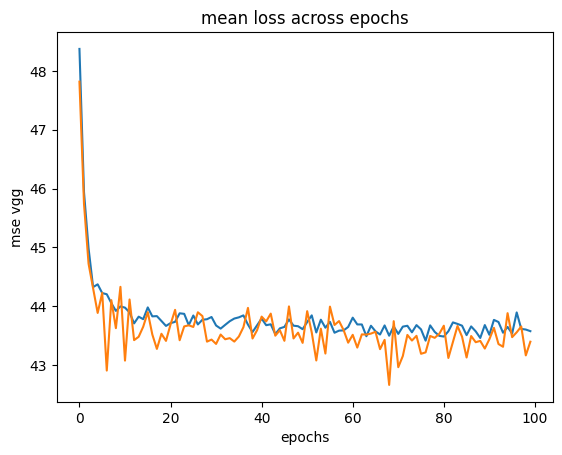

In [ ]:
from matplotlib import pyplot as plt
# htr_model.save("htr_model_vgg.keras")

plt.plot(epoch_loss, label = "training loss")
plt.plot(val_losses, label = "validation loss")
plt.xlabel("epochs")
plt.ylabel("mse vgg")
plt.title("mean loss across epochs")
plt.savefig("MeanvggEpochs.png", dpi=300, bbox_inches="tight")
plt.show()


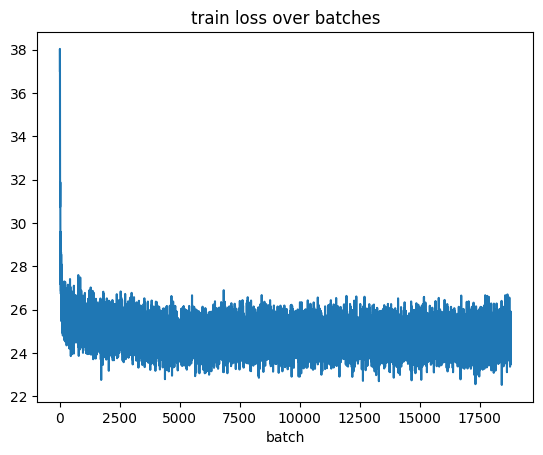

In [ ]:


plt.plot(all_batch_losses)
plt.xlabel("batch")
plt.title("train loss over batches")
plt.show()

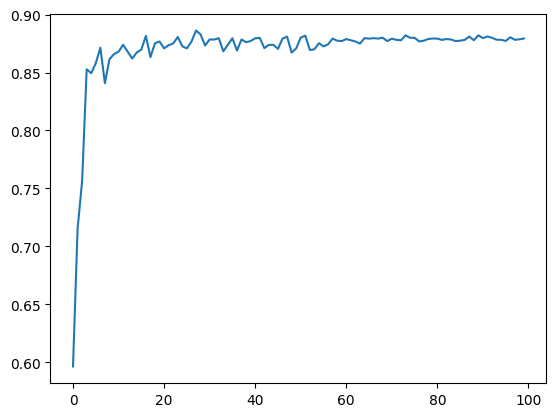

In [ ]:
plt.plot(accuracies)
plt.show()

In [ ]:
g_loss[-1]
accuracies[-1]

0.8793526785714285

In [ ]:
data = list(dataset.take(100))
images, one_hot_labels = data[0]

In [ ]:
images.shape

TensorShape([256, 28, 28, 1])

In [ ]:
pred_labels = htr_model(images[:5], training=False)
print(tf.one_hot(tf.argmax(pred_labels, axis=1), 10))
one_hot_labels[:5]

tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

tf.Tensor([5], shape=(1,), dtype=int64) [[0.    0.002 0.    0.    0.    0.998 0.    0.    0.    0.   ]]
tf.Tensor([2], shape=(1,), dtype=int64) [[0.    0.079 0.819 0.06  0.    0.    0.002 0.038 0.    0.   ]]
tf.Tensor([1], shape=(1,), dtype=int64) [[0.    0.992 0.001 0.    0.    0.001 0.001 0.005 0.    0.   ]]
tf.Tensor([0], shape=(1,), dtype=int64) [[0.364 0.039 0.001 0.019 0.001 0.033 0.393 0.001 0.001 0.148]]
tf.Tensor([9], shape=(1,), dtype=int64) [[0.    0.003 0.    0.    0.001 0.    0.    0.002 0.    0.993]]
tf.Tensor([4], shape=(1,), dtype=int64) [[0.    0.013 0.    0.    0.977 0.    0.    0.002 0.    0.008]]
tf.Tensor([2], shape=(1,), dtype=int64) [[0.    0.003 0.986 0.002 0.    0.    0.    0.005 0.    0.004]]
tf.Tensor([8], shape=(1,), dtype=int64) [[0.    0.002 0.    0.    0.    0.003 0.    0.001 0.989 0.005]]
tf.Tensor([5], shape=(1,), dtype=int64) [[0.004 0.26  0.    0.    0.    0.727 0.    0.001 0.006 0.001]]
tf.Tensor([8], shape=(1,), dtype=int64) [[0.002 0.001 0.    0.00

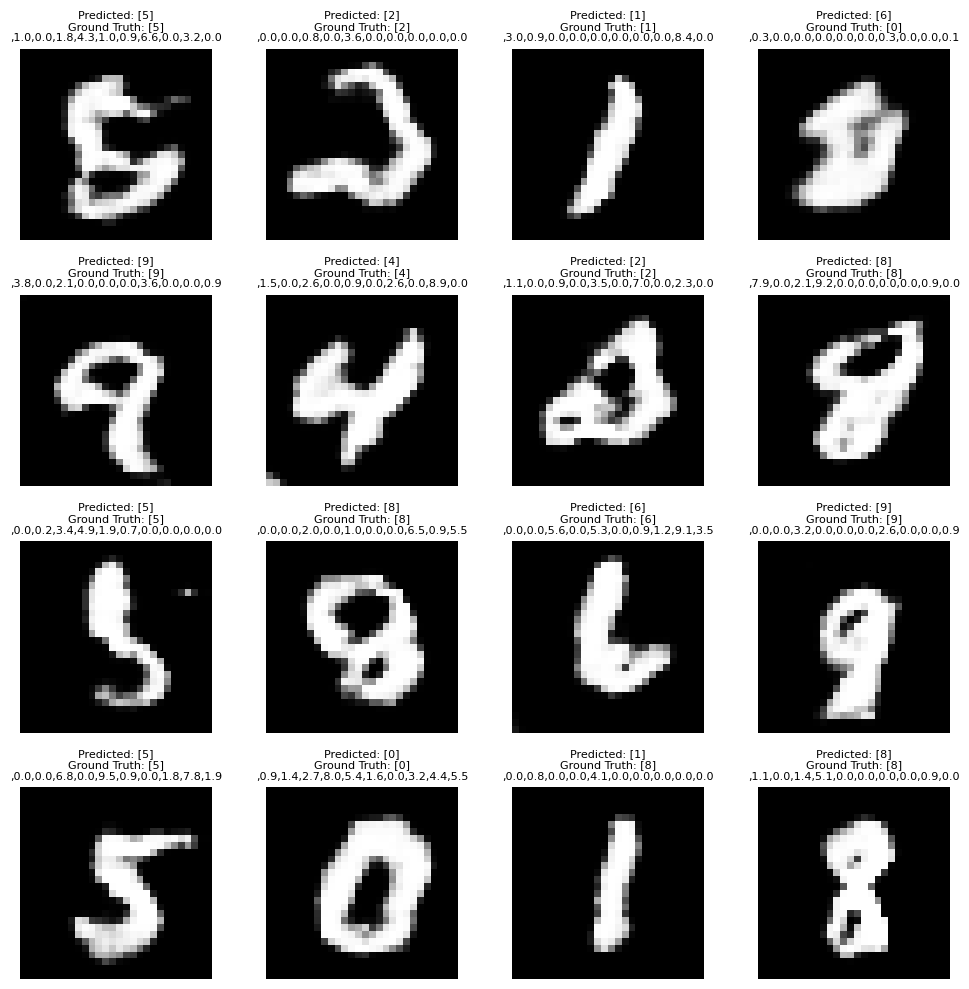

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Flatten the axs array to iterate over all subplots
axs = axs.flatten()

for i in range(16):
    pred = htr_model(images[i:(i+1)], training=False)

    pred_label = tf.argmax(pred, axis=1)
    
    gt_label = tf.argmax(one_hot_labels[i:(i+1)], axis=1)

    random_latent_vectors = tf.random.normal(
        shape=(1, latent_dim), seed=21
    )

    random_vector_labels = tf.concat(
        [random_latent_vectors, pred], axis=-1
    )
    gen_img = mnist_gen(random_vector_labels, training=False)
    # Plot image
    axs[i].imshow(tf.squeeze(gen_img), cmap='gray')
    axs[i].axis('off')  # Turn off axis
    
    # Add text above each pair of plots indicating predicted class and ground truth
    print(gt_label, np.round(pred.numpy(), 3))
    pred_str = ""
    for j in pred[0]:
        pred_str += "," + str(j.numpy())[:3]
    text = f'Predicted: {pred_label}\nGround Truth: {gt_label}\n' + pred_str
    axs[i].set_title(text, fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
def compute_accuracy(true_labels, predicted_labels):
    """
    Compute accuracy between true labels and predicted labels.

    Args:
    true_labels (list): List of true labels.
    predicted_labels (list): List of predicted labels.

    Returns:
    float: Accuracy as a value between 0 and 1.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Length of true labels and predicted labels must be the same.")

    correct_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
    total_samples = len(true_labels)

    accuracy = correct_predictions / total_samples if total_samples != 0 else 0

    return accuracy


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(256)

acc = []
for batch in tqdm(test_dataset):
    images, one_hot_labels = batch
    preds = htr_model(images, training=False)
    pred_labels = tf.argmax(preds, axis=1)
    gt_labels = tf.argmax(one_hot_labels, axis=1)
    acc.append(compute_accuracy(gt_labels, pred_labels))

print("Accuracy: ", np.mean(acc)*100)

100%|██████████| 40/40 [00:10<00:00,  3.70it/s]

Accuracy:  89.16015625
